In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

# -----------------------------
# 1. Download data
# -----------------------------
tickers = [
     "HDFCBANK.NS",
"BHARTIARTL.NS",
"TCS.NS",
"ICICIBANK.NS",
"INFY.NS",
"LT.NS",
"HINDUNILVR.NS",
"LICI.NS",
"MARUTI.NS",
"ITC.NS",
"HCLTECH.NS",
"KOTAKBANK.NS",
"SUNPHARMA.NS",
"TITAN.NS",
"ADANIPORTS.NS",
"NTPC.NS",
"ONGC.NS",
"HAL.NS",
"BEL.NS",
"ADANIPOWER.NS",
"ASIANPAINT.NS",
"BAJAJ-AUTO.NS",
"NESTLEIND.NS",
"DMART.NS",
"COALINDIA.NS",
"EICHERMOT.NS",
"SBILIFE.NS",
"HINDALCO.NS",
"HYUNDAI.NS",
"LTIM.NS",
"DLF.NS",
"ADANIGREEN.NS",
"VBL.NS",
"BPCL.NS",
"HDFCLIFE.NS",
"TECHM.NS",
"TRENT.NS",
"PIDILITIND.NS",
"BRITANNIA.NS",
"TORNTPHARM.NS",
"MOTHERSON.NS",
"GODREJCP.NS",
"BAJAJHLDNG.NS",
"ADANIENSOL.NS",
"CIPLA.NS",
"TATAPOWER.NS",
"GAIL.NS",
"ABB.NS",
"SOLARINDS.NS",
"LODHA.NS",
"DRREDDY.NS",
"BOSCHLTD.NS",
"INDHOTEL.NS",
"CGPOWER.NS",
"MAXHEALTH.NS",
"APOLLOHOSP.NS",
"MAZDOCK.NS",
"ICICIGI.NS",
"ZYDUSLIFE.NS",
"HAVELLS.NS",
]

data = yf.download(
    tickers,
    start="2018-01-01",
    progress=False,
    auto_adjust=False
)

# -----------------------------
# 2. Preserve raw prices
# -----------------------------
raw_close = data["Close"].copy()
raw_volume = data["Volume"].copy()

# Forward-fill per stock (NO cross-sectional dropna)
raw_close = raw_close.ffill()
raw_volume = raw_volume.ffill()

# -----------------------------
# 3. Build trading month-end calendar (CORRECT)
# -----------------------------
month_ends = (
    raw_close.index.to_series()
    .groupby([raw_close.index.year, raw_close.index.month])
    .last()
)

# -----------------------------
# 4. (Optional) sanity check
# -----------------------------
month_ends[:12]


Date  Date
2018  1      2018-01-31
      2      2018-02-28
      3      2018-03-28
      4      2018-04-30
      5      2018-05-31
      6      2018-06-29
      7      2018-07-31
      8      2018-08-31
      9      2018-09-28
      10     2018-10-31
      11     2018-11-30
      12     2018-12-31
Name: Date, dtype: datetime64[ns]

In [ ]:
# -----------------------------
# Phase 2: Benchmark-Relative Momentum Signal
# -----------------------------

# 1. Raw close (already from Phase 1)
raw_close = raw_close.copy()

# 2. Benchmark prices
benchmark = yf.download(
    "^CNX100",
    start=raw_close.index.min(),
    progress=False
)["Close"].ffill()

# 3. Monthly prices using PRECOMPUTED month_ends (DO NOT REBUILD)
monthly_prices = raw_close.reindex(month_ends, method="ffill")
benchmark_monthly = benchmark.reindex(month_ends, method="ffill")

# 4. 12-1 momentum
stock_mom_12_1 = monthly_prices.shift(1) / monthly_prices.shift(12) - 1
benchmark_mom_12_1 = (
    benchmark_monthly.shift(1) / benchmark_monthly.shift(12) - 1
).squeeze()

# 5. Benchmark-relative momentum
relative_momentum = stock_mom_12_1.sub(benchmark_mom_12_1, axis=0)

# 6. Volatility (12-month, daily)
daily_returns = raw_close.pct_change()
vol_12m = daily_returns.rolling(252).std() * np.sqrt(252)
vol_12m_monthly = vol_12m.reindex(month_ends, method="ffill")

# 7. FINAL SIGNAL (DO NOT RENAME)
monthly_scores = relative_momentum / vol_12m_monthly

/tmp/ipython-input-4189776615.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark = yf.download(


PHASE 3

In [ ]:
top_10_selection = {}

for date in monthly_scores.index:

    # 1. Drop NaNs explicitly
    scores = monthly_scores.loc[date].dropna()

    # 2. Skip month if not enough stocks
    if len(scores) < 10:
        continue

    # 3. Rank and select top 10
    top_10 = scores.sort_values(ascending=False).head(10).index.tolist()

    top_10_selection[date] = top_10


PHASE 4

In [ ]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 14.6 MB/s eta 0:00:00


In [ ]:
from pypfopt import expected_returns, risk_models, EfficientFrontier

RISK_FREE_RATE_ANNUAL = 0.052
LOOKBACK_DAYS = 36 * 21
MAX_WEIGHT = 0.15
MIN_EXCESS_RETURN = 0.01  # 1% annual buffer


def optimize_portfolio_capm_with_cash(
    close_prices,
    benchmark_prices,
    stocks,
    risk_free_rate,
    lookback_days=LOOKBACK_DAYS,
    max_weight=MAX_WEIGHT,
    min_excess_return=MIN_EXCESS_RETURN,
):
    # 1. Slice aligned history
    price_window = close_prices[stocks].tail(lookback_days)
    benchmark_window = benchmark_prices.reindex(price_window.index).ffill()

    # 2. CAPM expected returns (ANNUAL, EXCESS)
    mu = expected_returns.capm_return(
        price_window,
        market_prices=benchmark_window,
        risk_free_rate=risk_free_rate,
    )

    # 3. If no stock beats risk-free by buffer → go full cash
    if mu.max() < min_excess_return:
        return {s: 0.0 for s in stocks}, 1.0

    # 4. Covariance (annualized)
    cov = risk_models.sample_cov(price_window)

    # 5. Optimize (pure Max Sharpe)
    ef = EfficientFrontier(mu, cov, weight_bounds=(0, max_weight))
    ef.max_sharpe(risk_free_rate=0.0)

    weights = ef.clean_weights()
    cash_weight = 1 - sum(weights.values())

    return weights, cash_weight


PHASE 5

In [ ]:
# -----------------------------
# Phase 5: Monthly Backtest
# -----------------------------

risk_free_monthly = RISK_FREE_RATE_ANNUAL / 12

portfolio_returns = []
portfolio_dates = []

rebalance_dates = list(top_10_selection.keys())

for i in range(len(rebalance_dates) - 1):

    decision_date = rebalance_dates[i]
    holding_date = rebalance_dates[i + 1]

    stocks = top_10_selection[decision_date]

    # Optimize portfolio at decision date
    weights, cash_weight = optimize_portfolio_capm_with_cash(
        close_prices=raw_close,
        benchmark_prices=benchmark,
        stocks=stocks,
        risk_free_rate=RISK_FREE_RATE_ANNUAL
    )

    # -----------------------------
    # Equity return calculation
    # -----------------------------
    equity_return = 0.0

    for stock, weight in weights.items():
        if weight == 0:
            continue

        # Price-based return over holding period
        p0 = raw_close.loc[decision_date, stock]
        p1 = raw_close.loc[holding_date, stock]

        if pd.isna(p0) or pd.isna(p1):
            continue

        equity_return += weight * (p1 / p0 - 1)

    # -----------------------------
    # Cash return
    # -----------------------------
    cash_return = cash_weight * risk_free_monthly

    # Total portfolio return
    total_return = equity_return + cash_return

    portfolio_returns.append(total_return)
    portfolio_dates.append(holding_date)

# -----------------------------
# Results
# -----------------------------
portfolio_returns = pd.Series(
    portfolio_returns,
    index=portfolio_dates,
    name="Portfolio_Return"
)

portfolio_cumulative = (1 + portfolio_returns).cumprod()


In [ ]:
portfolio_returns.dropna().head(), portfolio_returns.dropna().tail()


(2019-02-28   -0.009331
 2019-03-28    0.036422
 2019-04-30    0.016833
 2019-05-31   -0.007515
 2019-06-28    0.010429
 Name: Portfolio_Return, dtype: float64,
 2025-09-30   -0.008352
 2025-10-31    0.024467
 2025-11-28    0.006597
 2025-12-31    0.022899
 2026-01-01   -0.000192
 Name: Portfolio_Return, dtype: float64)

PHASE 6

In [ ]:
# -----------------------------
# Core performance metrics
# -----------------------------

rf_monthly = RISK_FREE_RATE_ANNUAL / 12
rf_annual = RISK_FREE_RATE_ANNUAL

returns = portfolio_returns.dropna()

# CAGR
num_years = (returns.index[-1] - returns.index[0]).days / 365.25
cagr = (1 + returns).prod() ** (1 / num_years) - 1

# Volatility (annualized)
volatility = returns.std() * np.sqrt(12)

# Sharpe Ratio
sharpe = (returns.mean() * 12 - rf_annual) / volatility

# Sortino Ratio
downside_std = returns[returns < 0].std() * np.sqrt(12)
sortino = (returns.mean() * 12 - rf_annual) / downside_std

In [ ]:
# -----------------------------
# Drawdown & Calmar
# -----------------------------

cumulative = (1 + returns).cumprod()
rolling_max = cumulative.cummax()
drawdown = (cumulative / rolling_max) - 1

max_drawdown = drawdown.min()
calmar = cagr / abs(max_drawdown)

In [ ]:
performance_summary = pd.Series(
    {
        "CAGR": cagr,
        "Volatility": volatility,
        "Sharpe": sharpe,
        "Sortino": sortino,
        "Max Drawdown": max_drawdown,
        "Calmar": calmar,
    }
)

performance_summary


,0
CAGR,0.266822
Volatility,0.184700
Sharpe,1.074902
Sortino,1.351263
Max Drawdown,-0.260013
Calmar,1.026188


Benchmark Comparison

In [ ]:
# -----------------------------
# Benchmark comparison
# -----------------------------

benchmark_monthly = benchmark.reindex(portfolio_returns.index, method="ffill")
benchmark_returns = benchmark_monthly.pct_change().dropna()

benchmark_cumulative = (1 + benchmark_returns).cumprod()

In [ ]:
# Benchmark CAGR
bm_years = (benchmark_returns.index[-1] - benchmark_returns.index[0]).days / 365.25
benchmark_cagr = (1 + benchmark_returns).prod() ** (1 / bm_years) - 1

# Alpha (excess CAGR)
alpha = cagr - benchmark_cagr

benchmark_cagr, alpha


(Ticker
 ^CNX100    0.140818
 dtype: float64,
 Ticker
 ^CNX100    0.126003
 dtype: float64)

In [ ]:
alpha

,0
Ticker,
^CNX100,0.126003


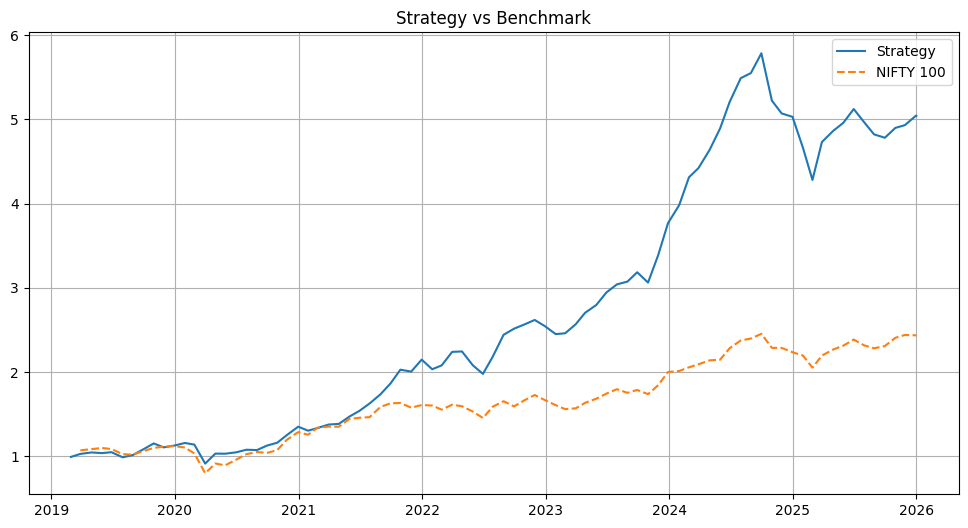

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(portfolio_cumulative, label="Strategy")
plt.plot(benchmark_cumulative, label="NIFTY 100", linestyle="--")
plt.title("Strategy vs Benchmark")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -----------------------------
# Beta calculation (monthly)
# -----------------------------

# Align returns
aligned_returns = pd.concat(
    [portfolio_returns, benchmark_returns],
    axis=1
).dropna()

aligned_returns.columns = ["Portfolio", "Benchmark"]

# Covariance matrix
cov_matrix = np.cov(
    aligned_returns["Portfolio"],
    aligned_returns["Benchmark"]
)

# Beta = Cov(P, B) / Var(B)
beta = cov_matrix[0, 1] / cov_matrix[1, 1]

beta


np.float64(0.884756354172964)

In [ ]:
cov_matrix

array([[0.00286623, 0.00214537],
       [0.00214537, 0.00242481]])

🟩 PHASE 7 — TAIL RISK, MONTE CARLO & STRESS TESTING

In [ ]:
# Use realized monthly portfolio returns
returns = portfolio_returns.dropna()

mean_return = returns.mean()
volatility = returns.std()

mean_return, volatility

(np.float64(0.02087783189929981), 0.05331818122530987)

In [ ]:
# -----------------------------
# Monte Carlo simulation
# -----------------------------

np.random.seed(42)

num_simulations = 10_000
num_months = len(returns)

simulated_paths = np.random.normal(
    loc=mean_return,
    scale=volatility,
    size=(num_simulations, num_months)
)

# Convert to cumulative returns
simulated_cumulative = (1 + simulated_paths).cumprod(axis=1)

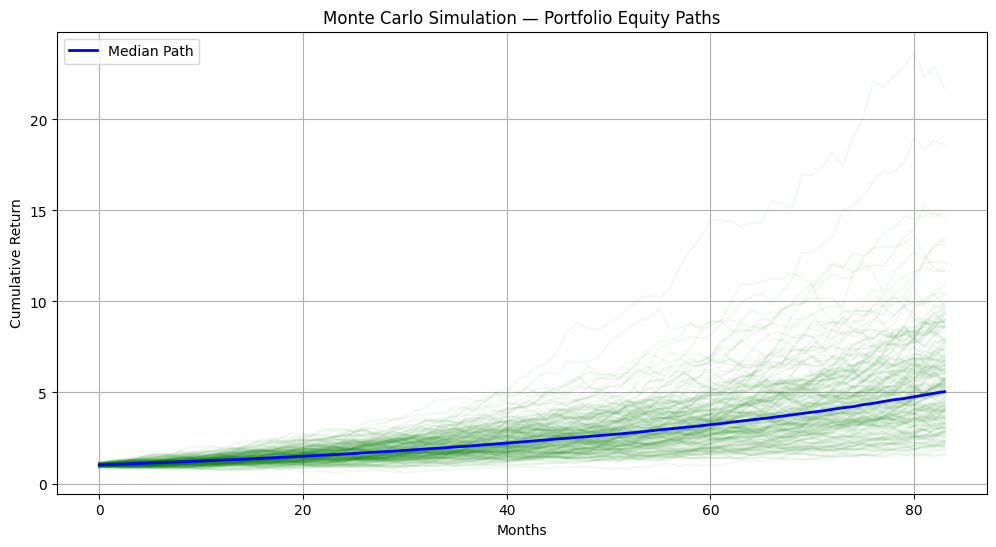

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot random subset of paths
for i in range(200):
    plt.plot(simulated_cumulative[i], color="green", alpha=0.05)

# Plot median path
plt.plot(
    np.median(simulated_cumulative, axis=0),
    color="blue",
    label="Median Path",
    linewidth=2
)

plt.title("Monte Carlo Simulation — Portfolio Equity Paths")
plt.xlabel("Months")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -----------------------------
# VaR & CVaR (monthly)
# -----------------------------

confidence_level = 0.95

var_95 = np.percentile(returns, (1 - confidence_level) * 100)

cvar_95 = returns[returns <= var_95].mean()

var_95, cvar_95

(np.float64(-0.0708347690521123), np.float64(-0.10474212148433866))

In [ ]:
# Flatten all simulated monthly returns
simulated_returns_flat = simulated_paths.flatten()

mc_var_95 = np.percentile(simulated_returns_flat, 5)
mc_cvar_95 = simulated_returns_flat[
    simulated_returns_flat <= mc_var_95
].mean()

mc_var_95, mc_cvar_95


(np.float64(-0.06681713000376963), np.float64(-0.08924489748451668))

In [ ]:
stress_3m = (1 + cvar_95) ** 3
stress_3m

np.float64(0.71753725498724)

In [ ]:
risk_summary = pd.Series(
    {
        "Historical VaR (95%)": var_95,
        "Historical CVaR (95%)": cvar_95,
        "Monte Carlo VaR (95%)": mc_var_95,
        "Monte Carlo CVaR (95%)": mc_cvar_95,
        "Worst 3M Stress Loss": stress_3m - 1,
    }
)

risk_summary

,0
Historical VaR (95%),-0.070835
Historical CVaR (95%),-0.104742
Monte Carlo VaR (95%),-0.066817
Monte Carlo CVaR (95%),-0.089245
Worst 3M Stress Loss,-0.282463


In [ ]:
# -----------------------------
# LIVE MONTHLY PORTFOLIO
# -----------------------------

# Latest rebalance date (last trading month-end)
latest_rebalance_date = month_ends.iloc[-1]

# Stocks selected for this month
current_stocks = top_10_selection.get(latest_rebalance_date)

if current_stocks is None:
    raise ValueError("No portfolio available for the latest month")

# Optimize portfolio
current_weights, current_cash_weight = optimize_portfolio_capm_with_cash(
    close_prices=raw_close,
    benchmark_prices=benchmark,
    stocks=current_stocks,
    risk_free_rate=RISK_FREE_RATE_ANNUAL
)

print(f"Portfolio Date: {latest_rebalance_date.date()}")
print("\nEquity Allocation:")
for k, v in current_weights.items():
    if v > 0:
        print(f"{k}: {round(v*100, 2)}%")

print(f"\nCash Allocation: {round(current_cash_weight*100, 2)}%")


Portfolio Date: 2026-01-01

Equity Allocation:
HINDALCO.NS: 10.53%
BPCL.NS: 10.64%
SBILIFE.NS: 15.0%
EICHERMOT.NS: 12.64%
MARUTI.NS: 15.0%
BHARTIARTL.NS: 15.0%
ADANIPORTS.NS: 3.88%
HYUNDAI.NS: 8.42%
BEL.NS: 8.46%
ADANIENSOL.NS: 0.43%

Cash Allocation: -0.0%
